In [1]:
import argparse
import subprocess, os
from process_data import *
import random
import numpy as np
import torch
from data.dataset import create_datasets
from Generator.Generator import generator
import yaml
import matplotlib.pyplot as plt

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
stream=open("Configs/MNIST/VAEAnneal.yaml", "r")
argsdict=yaml.safe_load(stream)
if argsdict['computer'] == 'home':
    argsdict['path'] = "/media/frederic/VAETI"
elif argsdict['computer'] == 'labo':
    argsdict['path'] = "/u/piedboef/Documents/VAETI"

if argsdict['dataset'] == "SST2":
    categories = ["neg", "pos"]
elif argsdict['dataset'] == "TREC6":
    categories = ["ABBR", "DESC", "ENTY", "HUM", "LOC", "NUM"]
elif argsdict['dataset'] == "FakeNews":
    categories = ["Fake", "Real"]
elif argsdict['dataset'] == "QNLI":
    categories = ["entailment", "not_entailment"]
elif argsdict['dataset'] == "Irony":
    categories = ["NotIro", "Iro"]
elif argsdict['dataset'] == "IronyB":
    categories = ["Clash", "Situational", "Other", "NotIro"]
elif argsdict['dataset'] == 'MNIST':
    categories = [0,1,2,3,4,5,6,7,8,9]
else:
    raise ValueError("Dataset not found")
argsdict['categories'] = categories

argdict=argsdict
    

In [2]:
train, dev, test=create_datasets(argdict)
Gen = generator(argdict, train, dev, test)
Gen.train()

VAE_model(
  (encoder): encoder(
    (model): Linear_Encoder(
      (fc1): Linear(in_features=784, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=256, bias=True)
      (hidden2mean): Linear(in_features=256, out_features=5, bias=True)
      (hidden2logv): Linear(in_features=256, out_features=5, bias=True)
    )
  )
  (decoder): decoder(
    (model): Linear_Decoder(
      (latent2hidden): Linear(in_features=5, out_features=256, bias=True)
      (fc5): Linear(in_features=256, out_features=512, bias=True)
      (fc6): Linear(in_features=512, out_features=784, bias=True)
    )
  )
)


/u/piedboef/Documents/VAETI/venv/lib/python3.10/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


TRAIN Epoch 0/30, Mean ELBO 156.67621428023938, Mean LF 148.26145935058594, Mean KL div 8.414749145507812
DEV Epoch 0/30, Mean ELBO 133.12252015705351, Mean LF 122.37936401367188, Mean KL div 10.74316120147705
TRAIN Epoch 1/30, Mean ELBO 129.77067704311636, Mean LF 118.89568328857422, Mean KL div 10.874999046325684
DEV Epoch 1/30, Mean ELBO 127.04831270628338, Mean LF 115.74713134765625, Mean KL div 11.301191329956055
TRAIN Epoch 2/30, Mean ELBO 125.56196566736975, Mean LF 114.3761978149414, Mean KL div 11.185773849487305
DEV Epoch 2/30, Mean ELBO 124.53540676454955, Mean LF 113.5411148071289, Mean KL div 10.994288444519043
TRAIN Epoch 3/30, Mean ELBO 123.12948924219886, Mean LF 111.71910095214844, Mean KL div 11.41038703918457
DEV Epoch 3/30, Mean ELBO 122.96337224260161, Mean LF 111.36544799804688, Mean KL div 11.597928047180176
TRAIN Epoch 4/30, Mean ELBO 121.3400059456049, Mean LF 109.76789855957031, Mean KL div 11.57210636138916
DEV Epoch 4/30, Mean ELBO 121.73791291442099, Mean L

/u/piedboef/Documents/VAETI/venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/u/piedboef/Documents/VAETI/venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


               x          y  labs  \
0      -2.306359 -41.934666   0.0   
1      -7.142377 -54.310604   0.0   
2      -7.685435  13.080273   7.0   
3      49.819038 -15.100550   4.0   
4      20.165785 -10.819726   4.0   
...          ...        ...   ...   
54995 -38.055260 -42.450294   0.0   
54996  17.428749  42.969555   1.0   
54997  57.844738   0.106846   4.0   
54998   9.952097   0.020924   9.0   
54999 -29.912725 -53.913471   0.0   

                                                  points  
0      [0.6487876772880554, 0.03528312221169472, -0.5...  
1      [-0.27501240372657776, -0.27837899327278137, -...  
2      [-0.745367705821991, -0.5140501260757446, 0.31...  
3      [-1.7919052839279175, 1.9089094400405884, -2.0...  
4      [-0.004313964396715164, 1.198323369026184, -0....  
...                                                  ...  
54995  [-0.4372551143169403, 0.46612030267715454, -1....  
54996  [0.8301223516464233, -0.5362904071807861, -0.6...  
54997  [-1.6772966384887

NameError: name 'sdffd' is not defined

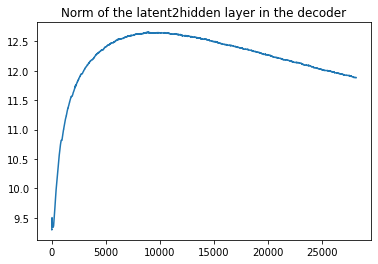

In [4]:
y=Gen.generator.model.decoder.norm
x=np.arange(len(y))

plt.plot(x,y)
plt.title("Norm of the latent2hidden layer in the decoder")
plt.show()